# Object Detection API Demo, now for Text Detection

<table align="left"><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

Welcome to the [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image.

> **Important**: This tutorial is to help you through the first step towards using [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to build models. If you just just need an off the shelf model that does the job, see the [TFHub object detection example](https://colab.sandbox.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).

# Setup

Important: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md). This notebook includes only what's necessary to run in Colab.

### Install

In [ ]:
#!pip install -U --pre tensorflow=="2.*"
#!pip install tf_slim

Make sure you have `pycocotools` installed

In [ ]:
#!pip install pycocotools

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [ ]:
#import os
#import pathlib


#if "models" in pathlib.Path.cwd().parts:
#  while "models" in pathlib.Path.cwd().parts:
#    os.chdir('..')
#elif not pathlib.Path('models').exists():
#  !git clone --depth 1 https://github.com/tensorflow/models

Compile protobufs and install the object_detection package

In [ ]:
#%%bash
#cd models/research/
#protoc object_detection/protos/*.proto --python_out=.

In [17]:
#%%bash 
#cd models/research
#pip install .
#!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=c2e8e14b22e57d7ae520fd92e18d3744d39c9023c96c23f13edca7ad65b6bf5e
  Stored in directory: c:\users\kenzi\appdata\local\pip\cache\wheels\67\71\6c\7a8c5ca2e699752506999ae7baeb692e2b4fc6488c2cddcb22
Successfully built pytesseract


### Imports

In [18]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib
import pytesseract as tess

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [19]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
import importlib
importlib.reload(vis_util)

<module 'object_detection.utils.visualization_utils' from 'C:\\Object_detection\\models-master\\research\\object_detection\\utils\\visualization_utils.py'>

Patches:

In [20]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## Loader

In [21]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [22]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'object_detection\images\label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity we will test on 2 images:

In [23]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[WindowsPath('object_detection/test_images/2.jpg'),
 WindowsPath('object_detection/test_images/29623277_041fdb3f-c226-4f48-b435-deffb6e7552d_2048_1915.jpg'),
 WindowsPath('object_detection/test_images/Cara-Aman-Minum-Paracetamol-dan-Efek-Sampingnya.jpg'),
 WindowsPath('object_detection/test_images/image1.jpg'),
 WindowsPath('object_detection/test_images/image2.jpg'),
 WindowsPath('object_detection/test_images/image4.jpg'),
 WindowsPath('object_detection/test_images/image5.jpg')]

# Detection

Load an object detection model:

In [24]:
#model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
#detection_model = load_model(model_name)
detection_model = tf.saved_model.load('object_detection/inference_graph/saved_model/')
#detection_model.summary()

Check the model's input signature, it expects a batch of 3-color images of type uint8:

In [9]:
print(detection_model.signatures['serving_default'].inputs)

[<tf.Tensor 'input_tensor:0' shape=(1, None, None, 3) dtype=uint8>, <tf.Tensor 'unknown:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_0:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_1:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_2:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_3:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_4:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_5:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_6:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_7:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_8:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_9:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_10:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_11:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_12:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_13:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_14:0' shape=<unknown> dtype=resource>, <

And returns several outputs:

In [10]:
detection_model.signatures['serving_default'].output_dtypes

{'raw_detection_scores': tf.float32,
 'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'raw_detection_boxes': tf.float32,
 'detection_anchor_indices': tf.float32,
 'num_detections': tf.float32,
 'detection_scores': tf.float32}

In [11]:
detection_model.signatures['serving_default'].output_shapes

{'raw_detection_scores': TensorShape([1, 12804, 2]),
 'detection_boxes': TensorShape([1, 100, 4]),
 'detection_classes': TensorShape([1, 100]),
 'detection_multiclass_scores': TensorShape([1, 100, 2]),
 'raw_detection_boxes': TensorShape([1, 12804, 4]),
 'detection_anchor_indices': TensorShape([1, 100]),
 'num_detections': TensorShape([1]),
 'detection_scores': TensorShape([1, 100])}

Add a wrapper function to call the model, and cleanup the outputs:

In [12]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.8,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [13]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      max_boxes_to_draw=3,
      min_score_thresh=.6,
      line_thickness=3)
  try:
      coordinates = vis_util.return_coordinates(
       image_np,
       output_dict['detection_boxes'],
       output_dict['detection_classes'],
       output_dict['detection_scores'],
       category_index,
       instance_masks=output_dict.get('detection_masks_reframed', None),
       use_normalized_coordinates=True,
       max_boxes_to_draw=3,
       min_score_thresh=.6,
       line_thickness=3)
      ymin=int(coordinates[0])
      ymax=int(coordinates[1])
      xmin=int(coordinates[2])
      xmax=int(coordinates[3])
      img = tf.image.crop_to_bounding_box(image_np, ymin, xmin, ymax - ymin, xmax - xmin)
      plt.imshow(img)
      plt.savefig("cropped.png")
      !python imagetotext.py
      
  except:
        pass
  
  print(coordinates)
  #plt.show()
  #print(output_dict['detection_boxes'])
  #print(output_dict['num_detections'])  
  display(Image.fromarray(image_np))

vs 150 175 200

300

[1001, 1076, 1217, 1423, 64.58936333656311]


2

[428, 498, 553, 627, 84.6251130104065]


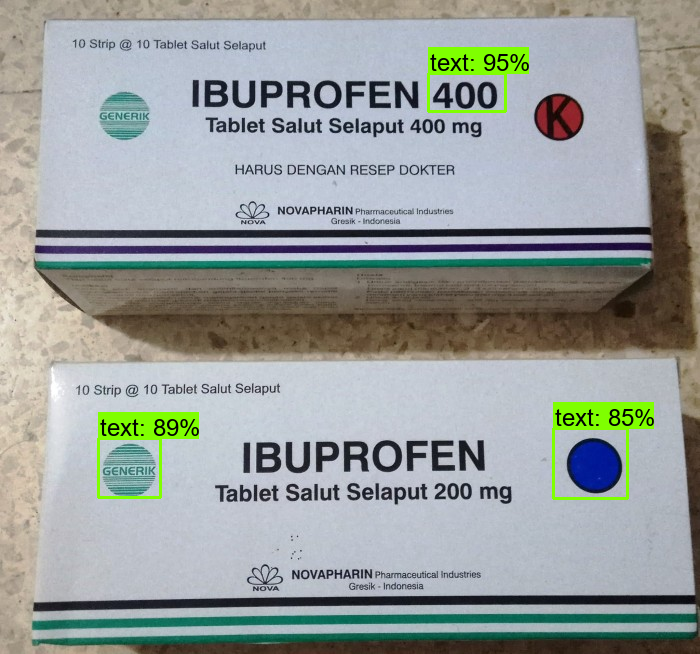

 [5, 52, 59, 367, 89.00477886199951]

[PARACETAMOL

300




300[0, 622, 0, 1024, 64.5923376083374]

200

300

400

500

600

 

0 200 400 600 800 3000




Traceback (most recent call last):
  File "imagetotext.py", line 8, in <module>
    print(text)
UnicodeEncodeError: 'cp932' codec can't encode character '\xab' in position 28: illegal multibyte sequence


[325, 441, 153, 544, 66.41138792037964]


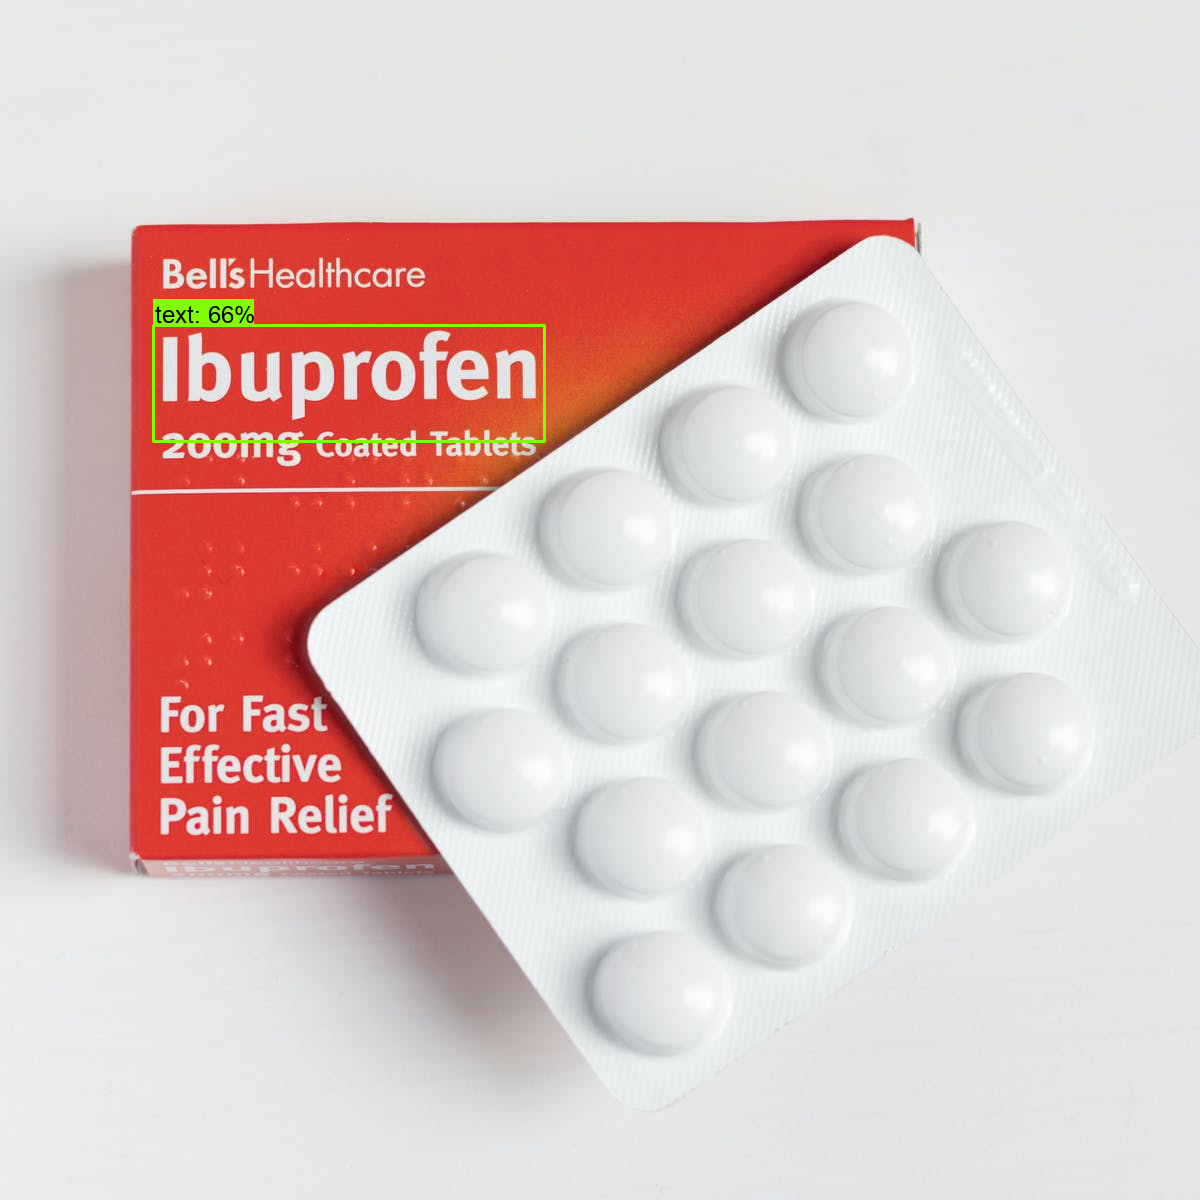

300[354, 379, 127, 228, 95.89040875434875]




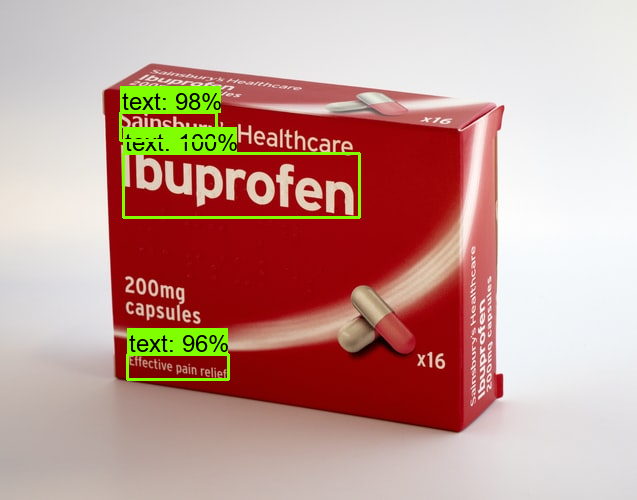

 

 

 

 

Hoa 8

300

300

250

200

150

100

[1187, 1290, 1131, 1439, 84.10834670066833]


In [14]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)


# to TFLite

In [25]:
CONFIG_FILE='object_detection\inference_graph\pipeline.config'
CHECKPOINT_PATH='object_detection\inference_graph\checkpoint'
OUTPUT_DIR='object_detection\inference_graph\tflite'

In [29]:
!python /content/drive/MyDrive/Tf2/object_detection/export_tflite_graph_tf2.py \
--pipeline_config_path=$CONFIG_FILE \
--trained_checkpoint_dir=$CHECKPOINT_PATH \
--output_directory=$OUTPUT_DIR \
#--add_postprocessing_op=true

Traceback (most recent call last):
  File "C:\Python37\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 64, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed: The paging file is too small for this operation to complete.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "object_detection/export_tflite_ssd_graph.py", line 95, in <module>
    import tensorflow.compat.v1 as tf
  File "C:\Python37\lib\site-packages\tensorflow\__init__.py", line 41, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "C:\Python37\lib\site-packages\tensorflow\python\__init__.py", line 40, in <module>
    from tensorflow.python.eager import context
  File "C:\Python37\lib\site-packages\tensorflow\python\eager\context.py", line 35, in <module>
    from tensorflow.python import pywrap_tfe
  File "C:\Python37\lib\site-packages\tensorflow\python\pywr

In [ ]:
import tensorflow as tf

saved_model_dir = 'object_detection\inference_graph\tflite\'

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)